Code for implementing VQVAE for CMPM280G seminar
References: Adam's Google Colab notebook

In [2]:
from pylab import *
import tensorflow as tf
print(tf.config.list_physical_devices())

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# MNIST input data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(f"x: {x_train.shape}@{x_train.dtype},\ny: {y_train.shape}@{y_train.dtype}")

x: (60000, 28, 28)@uint8,
y: (60000,)@uint8


In [98]:
# Vanilla encoder
# Define the encoder class
class VanillaEncoder:
  def __init__(self):
    self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(28,28)),
        tf.keras.layers.Reshape((28,28,1)),
        tf.keras.layers.Conv2D(
          32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.Conv2D(
        8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(28,28,1)),
        tf.keras.layers.Reshape((128,)),
        tf.keras.layers.Dense(32), #the bottleneck dimension          
      ], name='encoder')

encoderVanilla = VanillaEncoder()
encoderVanilla.network.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_63 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 16)          4624      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 4, 8)           1160      
_________________________________________________________________
reshape_64 (Reshape)         (None, 128)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                4128      
Total params: 10,232
Trainable params: 10,232
Non-trainable params: 0
_______________________________________________________

In [103]:
# Vanilla Decoder
class VanillaDecoder:
    def __init__(self):
        self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(32)),
        tf.keras.layers.Dense((128)), #32x32 output
        tf.keras.layers.Reshape((4,4,8)),
        tf.keras.layers.Conv2DTranspose(
          8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
         tf.keras.layers.Conv2DTranspose(
        1, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        #Make 32x32x1 into 28x28x1 (crop 2 values out)
        tf.keras.layers.Cropping2D(((2,2),(2,2))), 
        tf.keras.layers.Reshape((28,28)),           
      ], name='decoder')

decoderVanilla = VanillaDecoder()
decoderVanilla.network.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 128)               4224      
_________________________________________________________________
reshape_65 (Reshape)         (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_transpose_143 (Conv2D (None, 8, 8, 8)           584       
_________________________________________________________________
conv2d_transpose_144 (Conv2D (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_transpose_145 (Conv2D (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_transpose_146 (Conv2D (None, 32, 32, 1)         289       
_________________________________________________________________
cropping2d_11 (Cropping2D)   (None, 28, 28, 1)         0   

In [95]:
# Create a list of 32 images, each 28x28 pixels
grid_x = np.ndarray(shape=(32,28,28), dtype=uint8, order='F') 
for i in range(32):
    grid_x[i] = x_train[i]
print(grid_x.shape)
print(x_train.shape)

(32, 28, 28)
(60000, 28, 28)


In [74]:
# Define the group encoder class
class ImageGroupEncoder:
  def __init__(self):
    self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(32,28,28)),
        tf.keras.layers.Reshape((32,28,28,1)),
        tf.keras.layers.Conv2D(
          32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Conv2D(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Conv2D(
        8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', input_shape=(32,28,28,1)),
        tf.keras.layers.Reshape((32,128)),
        tf.keras.layers.Dense(32), #the bottleneck dimension          
      ], name='encoder')

encoder32 = ImageGroupEncoder()
encoder32.network.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 32, 28, 28, 1)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 14, 14, 32)    320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 7, 7, 16)      4624      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 4, 4, 8)       1160      
_________________________________________________________________
reshape_39 (Reshape)         (None, 32, 128)           0         
_________________________________________________________________
dense_34 (Dense)             (None, 32, 32)            4128      
Total params: 10,232
Trainable params: 10,232
Non-trainable params: 0
_______________________________________________________

In [93]:
### ========================= Group decoder does not work!==========================
# Define the group decoder class
class ImageGroupDecoder:
    def __init__(self):
        self.network = tf.keras.models.Sequential(
      [
        tf.keras.layers.Input(shape=(32,32)),
        tf.keras.layers.Dense((64)), #32x32 output
        tf.keras.layers.Reshape((32,16,4)),
        tf.keras.layers.Conv2DTranspose(
          8, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
          16, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(
        32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'),
         tf.keras.layers.Conv2DTranspose(
        1, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
        #Make 32x32x1 into 28x28x1 (crop 2 values out)
        tf.keras.layers.Cropping2D(((2,2),(2,2))), 
        #tf.keras.layers.Reshape((32,28,28)),           
      ], name='decoder')

decoder32 = ImageGroupDecoder()
decoder32.network.summary()   
    

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 32, 64)            2112      
_________________________________________________________________
reshape_58 (Reshape)         (None, 32, 16, 4)         0         
_________________________________________________________________
conv2d_transpose_139 (Conv2D (None, 64, 32, 8)         296       
_________________________________________________________________
conv2d_transpose_140 (Conv2D (None, 128, 64, 16)       1168      
_________________________________________________________________
conv2d_transpose_141 (Conv2D (None, 256, 128, 32)      4640      
_________________________________________________________________
conv2d_transpose_142 (Conv2D (None, 256, 128, 1)       289       
_________________________________________________________________
cropping2d_10 (Cropping2D)   (None, 236, 108, 1)       0   

In [107]:
# The Vanilla autoencoder network
class AutoencoderVanilla:
    def __init__(self, encoder, decoder):
        self.network = tf.keras.models.Sequential(
            [
                tf.keras.Input(shape=(28, 28)),
                encoder,
                decoder,
            ], name='autoencoder'
        )
autoencoderVanilla = AutoencoderVanilla(
    encoderVanilla.network, decoderVanilla.network)
ae = autoencoderVanilla.network

In [108]:
#Configure the model for training and then train
ae.compile(loss='MSE')
ae.fit(x_train, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 22s 11ms/step - loss: 1800.1104
Epoch 2/10
1875/1875 [==============================] - 20s 11ms/step - loss: 898.7874
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 728.1477
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 653.6108
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 607.5345
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 575.2391
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 551.5765
Epoch 8/10
1875/1875 [==============================] - 20s 11ms/step - loss: 533.5903
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 518.9187
Epoch 10/10
1875/1875 [==============================] - 20s 11ms/step - loss: 507.4446


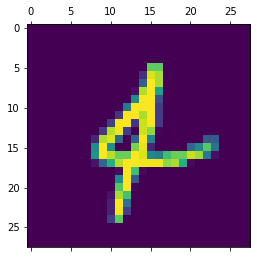

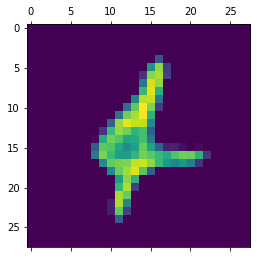

In [109]:
#Check if it works
matshow(x_test[300])
matshow((ae.predict(x_test[300][None]))[0])

In [118]:
# Code taken and modified from https://github.com/HenningBuhl/VQ-VAE_Keras_Implementation/blob/master/VQ_VAE_Keras_MNIST_Example.ipynb by Github user HenningBuhl and Adam's Colab notebook
class vectorQuantizerLayer(tf.keras.layers.Layer):
    def __init__(self, codebook_dim, codebook_number, initializer='uniform'):
        super(vectorQuantizerLayer, self).__init__()
        self.codebook_dim = codebook_dim
        self.codebook_number = codebook_number
        self.codebook = self.add_weight(
            shape=(codebook_dim, codebook_number), 
            initializer=initializer,
            trainable=True)

    def call(self, x):
        # Reshape the input according to the codebook vector dimensions
        reshaped_x = tf.keras.backend.reshape(x, (-1,self.codebook_dim))

        # Calculate eucledian distances of the input to the codebook vectors. This is basically (a-b)^2 = a^2 + 2*a*b + b^2 in matrix form. 
        distances = (
            tf.keras.backend.sum(reshaped_x**2, axis=1, keepdims=True) 
                - 2*tf.keras.backend.dot(reshaped_x, self.codebook) 
                + tf.keras.backend.sum(self.codebook**2, axis=0, keepdims=True))

        # Identify the codebook indices with minimum distances
        self.codebook_indices = tf.keras.backend.argmin(distances, axis=1)
        codebook = tf.keras.backend.one_hot(
            self.codebook_indices, self.codebook_number)
        print(f"The codebook vector is: {codebook}")

        #Do a lookup of the chosen index in the codebook
        quantized_output = tf.nn.embedding_lookup(
            tf.keras.backend.transpose(self.codebook), self.codebook_indices)
        return quantized_output


vq = vectorQuantizerLayer(32, 10)
vq.call(encoderVanilla.network.predict(x_train[300][None]))

The codebook vector is: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.02999753,  0.04207791, -0.00094951, -0.03881069, -0.03528434,
        -0.04200214,  0.03264326,  0.04025086,  0.04227425, -0.03485636,
        -0.01010508, -0.00424366, -0.00406509,  0.02293909,  0.02692971,
        -0.01458545, -0.03743865,  0.00634218,  0.04370398, -0.0484    ,
        -0.01419572, -0.04255999,  0.02697334,  0.02508697, -0.01274937,
        -0.03194635,  0.00066652,  0.03106382, -0.03279785, -0.01625267,
        -0.03076564, -0.0342647 ]], dtype=float32)>

In [119]:
# The vector quantized autoencoder network
class AutoencoderVectorQuantized:
    def __init__(self, encoder, vq, decoder):
        self.network = tf.keras.models.Sequential(
            [
                tf.keras.Input(shape=(28, 28)),
                encoder,
                vq,
                decoder,
            ], name='autoencoderVectorQuantized'
        )
autoencoderVectorQuantized = AutoencoderVectorQuantized(
    encoderVanilla.network, vq, decoderVanilla.network)
ae = autoencoderVectorQuantized.network

The codebook vector is: Tensor("vector_quantizer_layer_27/one_hot:0", shape=(None, 10), dtype=float32)


In [121]:
#Configure the model for training and then train
ae.compile(loss='MSE')
ae.fit(x_train, x_train, epochs=50)

Epoch 1/50
The codebook vector is: Tensor("autoencoderVectorQuantized/vector_quantizer_layer_27/one_hot:0", shape=(32, 10), dtype=float32)
The codebook vector is: Tensor("autoencoderVectorQuantized/vector_quantizer_layer_27/one_hot:0", shape=(32, 10), dtype=float32)
1875/1875 [==============================] - 16s 8ms/step - loss: 7282.9678
Epoch 2/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9663
Epoch 3/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9727
Epoch 4/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9658
Epoch 5/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9746
Epoch 6/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9712
Epoch 7/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9629
Epoch 8/50
1875/1875 [==============================] - 15s 8ms/step - loss: 7282.9717
Epoch 9/50
1875/1875 [==========================

KeyboardInterrupt: 

In [ ]:
matshow(x_test[300])
matshow((ae.predict(x_test[300][None]))[0])